In [4]:
import math
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
import tensorflow as tf
import keras
from keras.models import Model
from pathlib import Path
from matplotlib import pyplot as plt


TARGET_SIZE = (224, 224)
BATCH_SIZE = 32
DESIRED_TRAIN_SIZE = 100


img_path = Path("training")

train_ds: tf.data.Dataset = keras.preprocessing.image_dataset_from_directory(
    img_path,
    labels=None,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
)
img_count = len(train_ds.file_paths)
factor = math.ceil(DESIRED_TRAIN_SIZE / img_count)


data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.Rescaling(1.0 / 255),
        keras.layers.experimental.preprocessing.RandomRotation(0.1),
        keras.layers.experimental.preprocessing.RandomWidth(0.1),
        keras.layers.experimental.preprocessing.RandomHeight(0.1),
        keras.layers.experimental.preprocessing.RandomZoom(0.1),
        keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        keras.layers.experimental.preprocessing.Resizing(*TARGET_SIZE),
    ]
)

train_ds = train_ds.repeat(factor).map(
    lambda x: (data_augmentation(x, training=True), data_augmentation(x, training=True))
)


model = tf.keras.applications.MobileNetV3Large(weights="imagenet", include_top=False)
features = model.predict(train_ds)
features = features.reshape(features.shape[0], -1)

svm = OneClassSVM()
anomaly_scorer = make_scorer(
    lambda estimator, X: -estimator.decision_function(X).ravel()
)

param_grid = {"nu": [0.01, 0.05, 0.1, 0.5], "gamma": ["scale", "auto"], "kernel": ["rbf"]}

grid_search = GridSearchCV(svm, param_grid, scoring=anomaly_scorer, cv=5, n_jobs=-1)

grid_search.fit(features)

best_svm = grid_search.best_estimator_

Found 1 files belonging to 1 classes.
100/100 [==============================] - 6s 54ms/step


/home/spark343/github/capturing_opportunities_capstone/jupyter_lab/poc/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/spark343/github/capturing_opportunities_capstone/jupyter_lab/poc/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/spark343/github/capturing_opportunities_capstone/jupyter_lab/poc/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/spark343/github/capturin

In [14]:
img_path = Path("collection")

collection_ds: tf.data.Dataset = keras.preprocessing.image_dataset_from_directory(
    img_path,
    labels=None,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
)


file_paths = [Path(path) for path in collection_ds.file_paths]
# file_paths = map(collection_ds.file_paths, Path)

data_augmentation = keras.Sequential(
    [
        keras.layers.Rescaling(1.0 / 255),
        keras.layers.Resizing(*TARGET_SIZE),
    ]
)

collection_ds = collection_ds.map(
    data_augmentation, num_parallel_calls=tf.data.AUTOTUNE
)

features = model.predict(collection_ds)
features = features.reshape(features.shape[0], -1)

errors = best_svm.decision_function(features)

results = zip(file_paths, errors)
results = sorted(results, key=lambda x: x[1])

Found 49 files belonging to 1 classes.
2/2 [==============================] - 2s 149ms/step


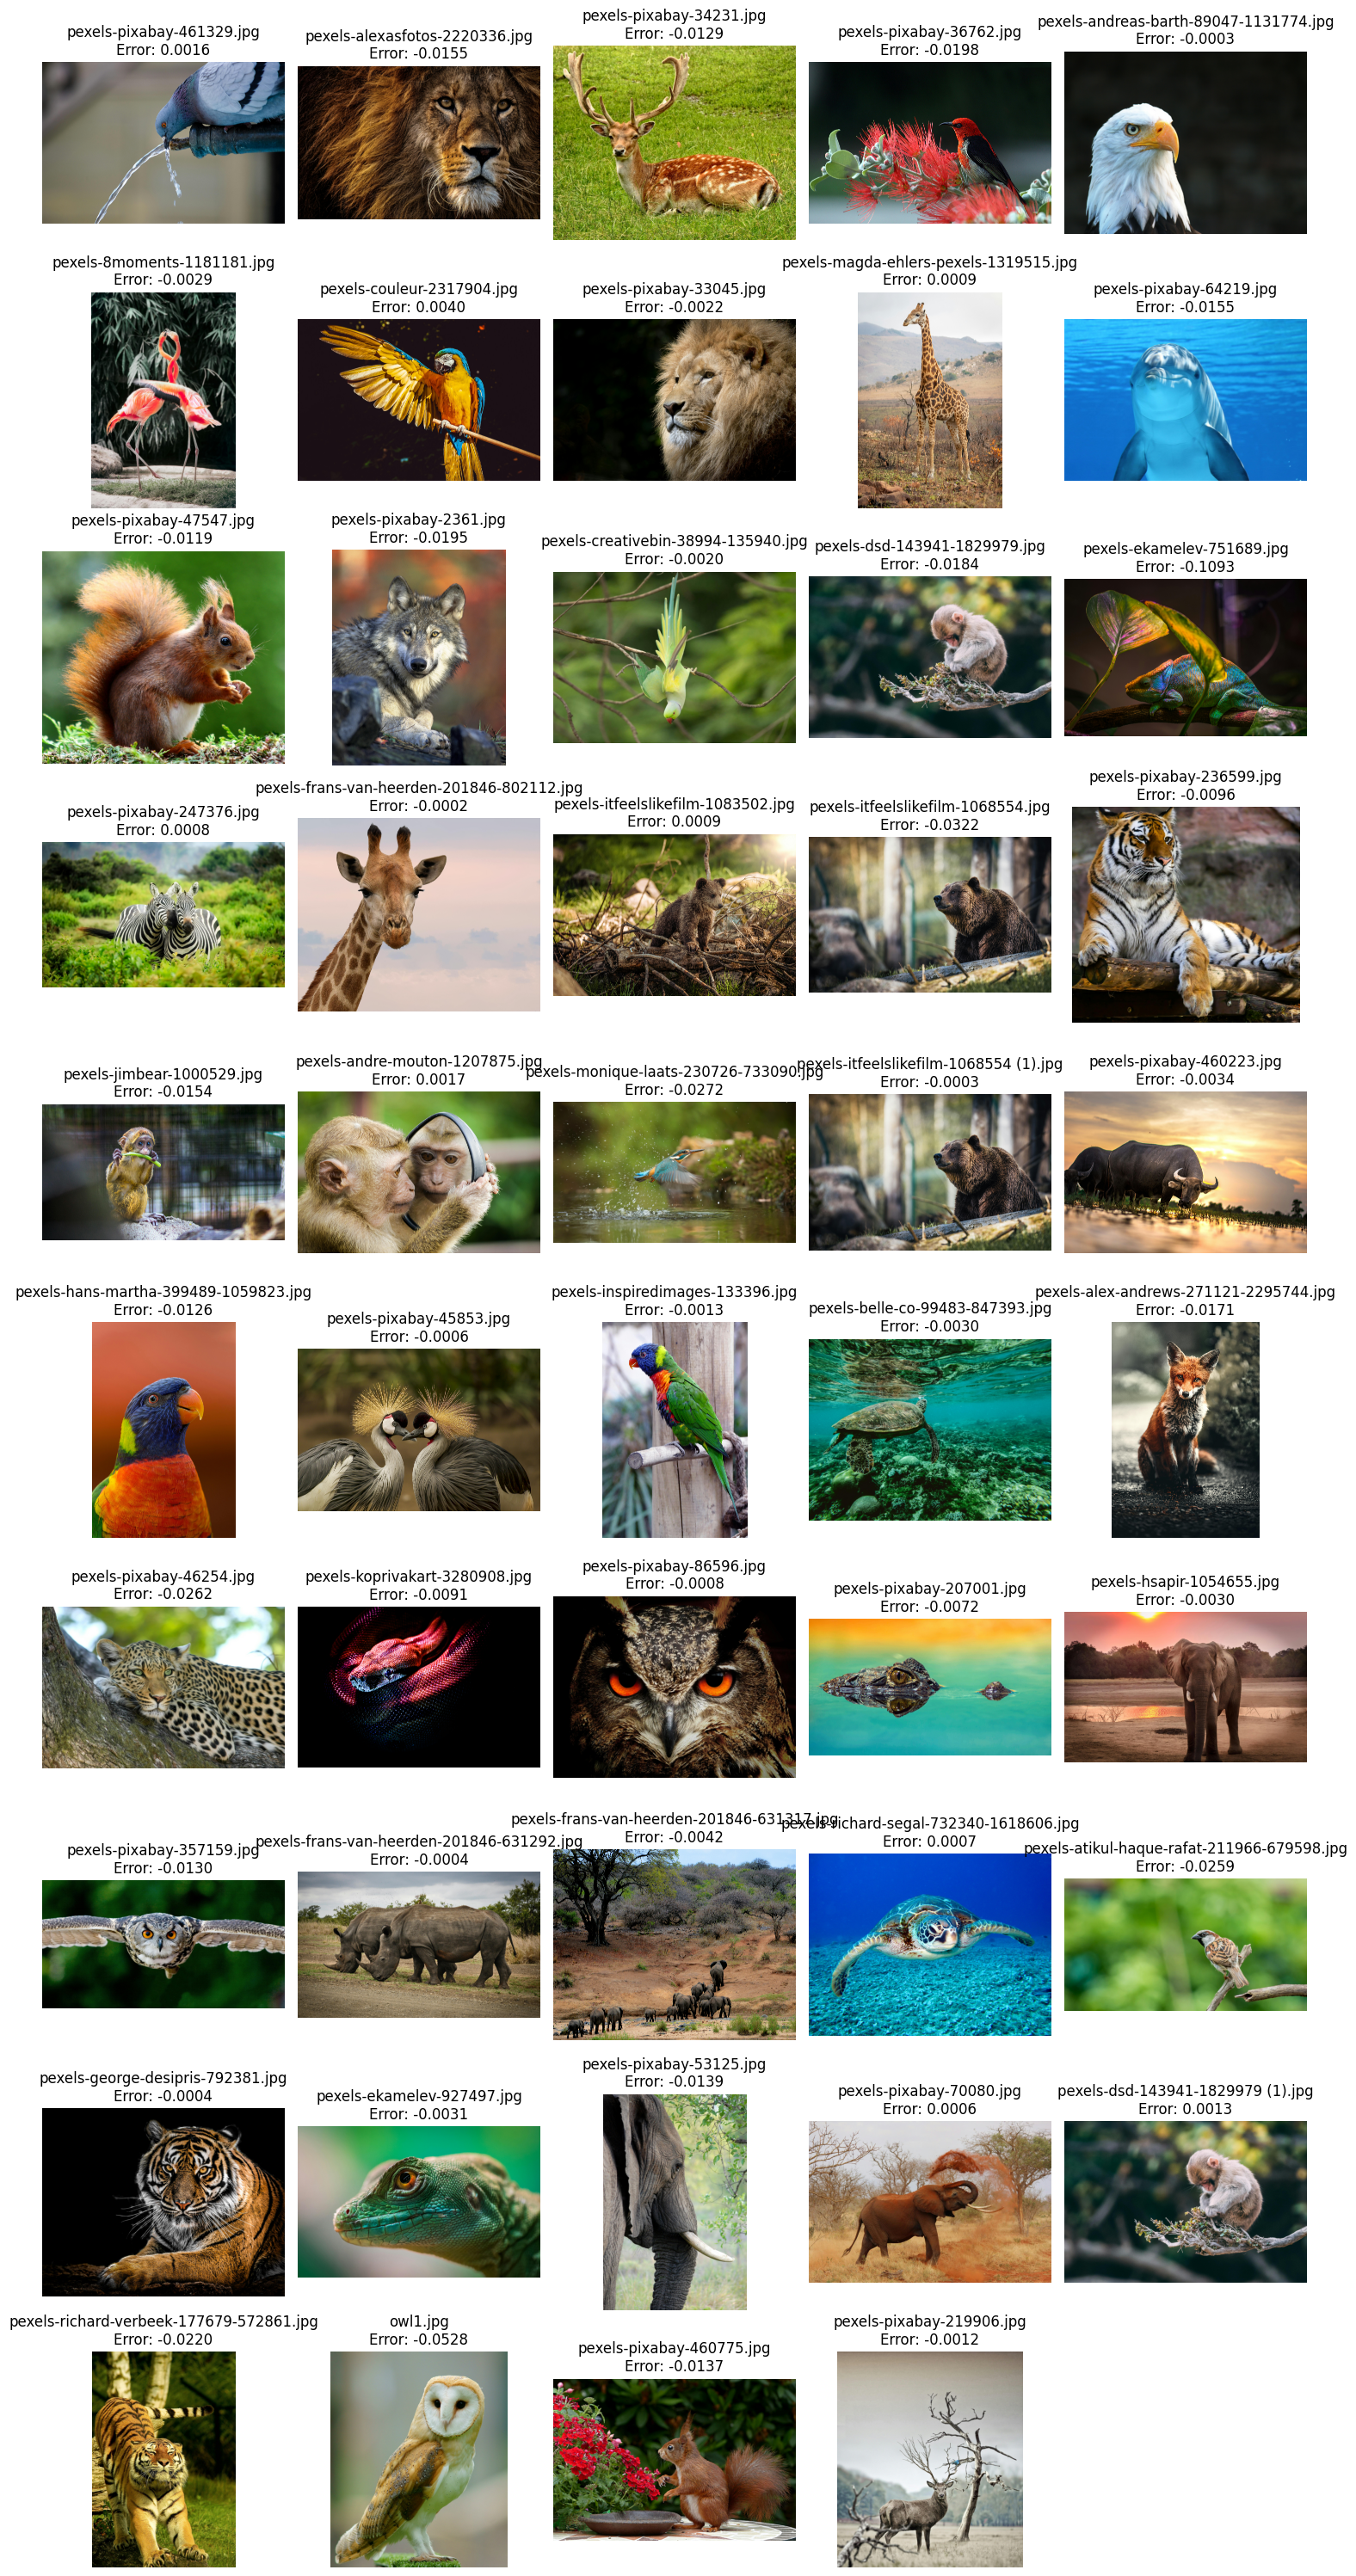

In [15]:
def display_images_with_labels_and_errors(paths, errors, cols=5):
    num_images = len(paths)
    rows = math.ceil(num_images / cols)

    _, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    axes = axes.flatten()

    for i in range(num_images):
        axes[i].imshow(plt.imread(paths[i]))
        axes[i].set_title(f"{paths[i].name}\nError: {errors[i]:.4f}")
        axes[i].axis("off")

    for j in range(num_images, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

display_images_with_labels_and_errors(file_paths, errors)